<a href="https://colab.research.google.com/github/O-Kpy/Project/blob/main/Kaggle_nyc_taxi_trip_duration_%ED%94%8C%EC%A0%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from math import sin, cos, sqrt, atan2, radians
from scipy import stats
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn.preprocessing import LabelEncoder, StandardScaler

In [120]:
train = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/nyc-taxi-trip-duration_train.csv')
test = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/nyc-taxi-trip-duration_test.csv')
submit = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/nyc-taxi-trip-durationsample_submission.csv')
train.shape, test.shape, submit.shape

((1458644, 11), (625134, 9), (625134, 2))

# 만들 columns 

1. distance(pickup_lon - dropoff_lon, pickup_lat-dropoff_lat, np.sqrt(np.square(train['dist_long']) + np.square(train['dist_lat'])))
2. clustering
3. speed(100000*train['dist'] / train['trip_duration'])  ==> test는 못 만드니까 지워야 함
4. 시계열 columns (pickup 시계열로)

---
# Feature Engineering


In [121]:
# 시계열 컬럼
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')

train['month'] = train['pickup_datetime'].dt.month
train['day'] = train['pickup_datetime'].dt.day
train['hour'] = train['pickup_datetime'].dt.hour
train['minute'] = train['pickup_datetime'].dt.minute
train['weekday'] = train['pickup_datetime'].dt.weekday
train['weekend'] = train['weekday'].apply(lambda x: 1 if x in [5,6] else 0)

test['month'] = test['pickup_datetime'].dt.month
test['day'] = test['pickup_datetime'].dt.day
test['hour'] = test['pickup_datetime'].dt.hour
test['minute'] = test['pickup_datetime'].dt.minute
test['weekday'] = test['pickup_datetime'].dt.weekday
test['weekend'] = test['weekday'].apply(lambda x: 1 if x in [5,6] else 0)

In [122]:
# store_and_fwd_flag FE 
train['store_and_fwd_flag'] = train['store_and_fwd_flag'].replace({'N':0, 'Y':1})
test['store_and_fwd_flag'] = test['store_and_fwd_flag'].replace({'N':0, 'Y':1})

In [123]:
def calculateBearing(lat1,lng1,lat2,lng2):
    R = 6371 
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

def calculateDistance(row):
    R=6373.0 # approximate radius of earth in km
    pickup_lat=radians(row['pickup_latitude'])
    pickup_lon=radians(row['pickup_longitude'])
    dropoff_lat=radians(row['dropoff_latitude'])
    dropoff_lon=radians(row['dropoff_longitude'])

    dlon = dropoff_lon - pickup_lon
    dlat = dropoff_lat - pickup_lat

    a = sin(dlat / 2)**2 + cos(pickup_lat) * cos(dropoff_lat) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    return distance

def feature_construct(df):  # 파생변수 컬럼
  # distance feautres
  df['dist_long'] = df['pickup_longitude'] - df['dropoff_longitude']
  df['dist_lat'] = df['pickup_latitude'] - df['dropoff_latitude']
  df['dist'] = np.sqrt(np.square(df['dist_long']) + np.square(df['dist_lat']))
  

  df['dist_long'] = np.abs(df['dist_long'])
  df['dist_lat'] = np.abs(df['dist_lat'])

  # 어디에서 어디까지 탔는가를 value_counts() ==> 구간별로 걸리는 시간(trip_duration)이 다를수도 있기 때문
  df['pickup_longitude_bin'] = np.round(df['pickup_longitude'], 3)
  df['pickup_latitude_bin'] = np.round(df['pickup_latitude'], 3)
  df['dropoff_longitude_bin'] = np.round(df['dropoff_longitude'], 3)
  df['dropoff_latitude_bin'] = np.round(df['dropoff_latitude'], 3)

  # df['pickup_longitude_bin'] = np.round(df['pickup_longitude'], 2)  # 그런데 위경도가 너무 크지 않나...? 
  # df['pickup_latitude_bin'] = np.round(df['pickup_latitude'], 2)
  # df['dropoff_longitude_bin'] = np.round(df['dropoff_longitude'], 2)
  # df['dropoff_latitude_bin'] = np.round(df['dropoff_latitude'], 2)

  # distance 구하기
  df['bearing_distance'] = df.apply(lambda x: calculateBearing(x['pickup_latitude_bin'], x['pickup_longitude_bin'], x['dropoff_latitude_bin'], x['dropoff_longitude_bin']), axis=1)
  df['cal_distance'] = df.apply(lambda x: calculateDistance(x), axis=1)


  return df

In [124]:
train = feature_construct(train)
test = feature_construct(test)

In [125]:
a = pd.concat([train,test]).groupby(['pickup_longitude_bin', 'pickup_latitude_bin']).size().reset_index(name='bin_valuecounts')
b = pd.concat([train,test]).groupby(['dropoff_longitude_bin', 'dropoff_latitude_bin']).size().reset_index(name='bin_valuecounts')

train = train.merge(a, on=['pickup_longitude_bin', 'pickup_latitude_bin'], how='left')
test = test.merge(a, on=['pickup_longitude_bin', 'pickup_latitude_bin'], how='left')

train = train.merge(b, on=['dropoff_longitude_bin', 'dropoff_latitude_bin'], how='left')
test = test.merge(b, on=['dropoff_longitude_bin', 'dropoff_latitude_bin'], how='left')

train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,month,day,hour,minute,weekday,weekend,dist_long,dist_lat,dist,pickup_longitude_bin,pickup_latitude_bin,dropoff_longitude_bin,dropoff_latitude_bin,bearing_distance,cal_distance,bin_valuecounts_x,bin_valuecounts_y
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,455,3,14,17,24,0,0,0.017525,0.002335,0.017680,-73.982,40.768,-73.965,40.766,98.823984,1.498991,5256,602
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,663,6,12,0,43,6,1,0.019066,0.007412,0.020456,-73.980,40.739,-73.999,40.731,-119.053505,1.806074,1010,394
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,1,19,11,35,1,0,0.026306,0.053852,0.059934,-73.979,40.764,-74.005,40.710,-159.948291,6.387103,1132,264
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,429,4,6,19,32,2,0,0.002228,0.013252,0.013438,-74.010,40.720,-74.012,40.707,-173.347990,1.485965,1190,636
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,435,3,26,13,30,5,1,0.000130,0.010689,0.010690,-73.973,40.793,-73.973,40.783,180.000000,1.188962,1482,442


In [126]:
# speed columns 이용
train['speed'] = 100000*train['dist'] / train['trip_duration']

In [127]:
a = train.groupby(['pickup_longitude_bin', 'pickup_latitude_bin'])['speed'].mean().reset_index(name='avg_speed')
b = train.groupby(['dropoff_longitude_bin', 'dropoff_latitude_bin'])['speed'].mean().reset_index(name='avg_speed')

train = train.merge(a, on=['pickup_longitude_bin', 'pickup_latitude_bin'], how='left')
train = train.merge(b, on=['dropoff_longitude_bin', 'dropoff_latitude_bin'], how='left')

test = test.merge(a, on=['pickup_longitude_bin', 'pickup_latitude_bin'], how='left')
test = test.merge(b, on=['dropoff_longitude_bin', 'dropoff_latitude_bin'], how='left')

train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,month,day,hour,minute,weekday,weekend,dist_long,dist_lat,dist,pickup_longitude_bin,pickup_latitude_bin,dropoff_longitude_bin,dropoff_latitude_bin,bearing_distance,cal_distance,bin_valuecounts_x,bin_valuecounts_y,speed,avg_speed_x,avg_speed_y
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,455,3,14,17,24,0,0,0.017525,0.002335,0.017680,-73.982,40.768,-73.965,40.766,98.823984,1.498991,5256,602,3.885613,3.347062,3.354606
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,663,6,12,0,43,6,1,0.019066,0.007412,0.020456,-73.980,40.739,-73.999,40.731,-119.053505,1.806074,1010,394,3.085355,3.678684,3.408484
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,1,19,11,35,1,0,0.026306,0.053852,0.059934,-73.979,40.764,-74.005,40.710,-159.948291,6.387103,1132,264,2.821742,3.317220,4.552624
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,429,4,6,19,32,2,0,0.002228,0.013252,0.013438,-74.010,40.720,-74.012,40.707,-173.347990,1.485965,1190,636,3.132449,4.069836,4.190553
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,435,3,26,13,30,5,1,0.000130,0.010689,0.010690,-73.973,40.793,-73.973,40.783,180.000000,1.188962,1482,442,2.457372,4.437244,4.029664


In [ ]:
# clustering
from sklearn.cluster import KMeans

longi = np.vstack((train[['pickup_longitude_bin', 'pickup_latitude_bin']],
                  train[['dropoff_longitude_bin', 'dropoff_latitude_bin']],
                  test[['pickup_longitude_bin', 'pickup_latitude_bin']],
                  test[['dropoff_longitude_bin', 'dropoff_latitude_bin']]))
# Elbow method
sse = {}
for i in range(1,11, 1):
  km = KMeans(n_clusters=i, max_iter=1000, random_state=42).fit(longi)
  sse[i] = km.inertia_

Text(0.5, 1.0, 'Elbow Method')

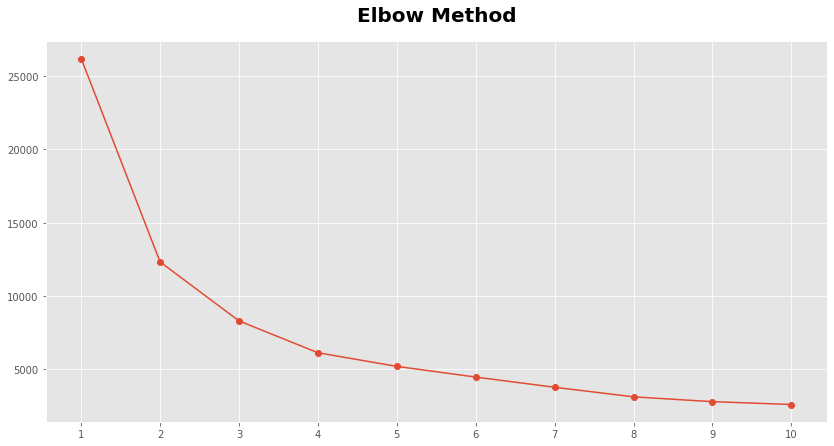

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(pd.Series(sse).index, pd.Series(sse), marker='o')
plt.xticks(pd.Series(sse).index)
plt.title('Elbow Method', fontsize=20, fontweight='bold', pad=20)

Text(0.5, 1.0, 'scatter map for clustering')

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



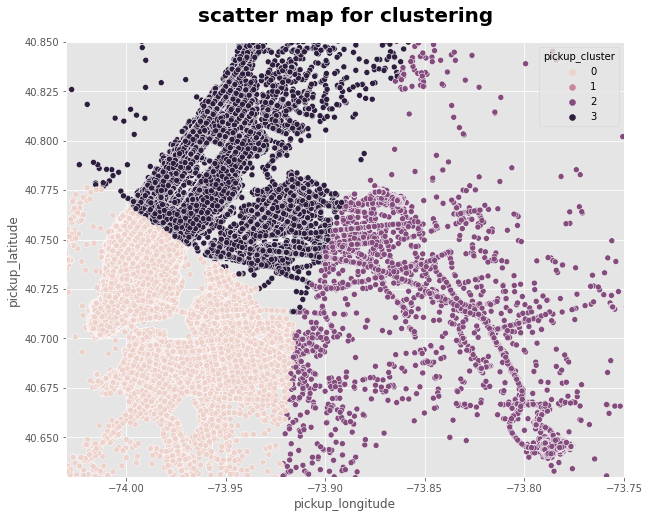

In [128]:
# predict
from sklearn.cluster import KMeans

longi = np.vstack((train[['pickup_longitude_bin', 'pickup_latitude_bin']],
                  train[['dropoff_longitude_bin', 'dropoff_latitude_bin']],
                  test[['pickup_longitude_bin', 'pickup_latitude_bin']],
                  test[['dropoff_longitude_bin', 'dropoff_latitude_bin']]))

km = KMeans(n_clusters=4, max_iter=1000, random_state=42).fit(longi)

train['pickup_cluster'] = km.predict(train[['pickup_longitude_bin', 'pickup_latitude_bin']])
train['dropoff_cluster'] = km.predict(train[['dropoff_longitude_bin', 'dropoff_latitude_bin']])

test['pickup_cluster'] = km.predict(test[['pickup_longitude_bin', 'pickup_latitude_bin']])
test['dropoff_cluster'] = km.predict(test[['dropoff_longitude_bin', 'dropoff_latitude_bin']])

# visualize
plt.figure(figsize=(10,8))
sns.scatterplot(x=train['pickup_longitude'], y=train['pickup_latitude'], hue=train['pickup_cluster'], data=train)
plt.xlim((-74.03, -73.75))
plt.ylim((40.63, 40.85))
plt.title('scatter map for clustering', fontsize=20, pad=20, fontweight='bold')

# Data preprocessing

Text(0.5, 1.0, 'Distribution After log1p')

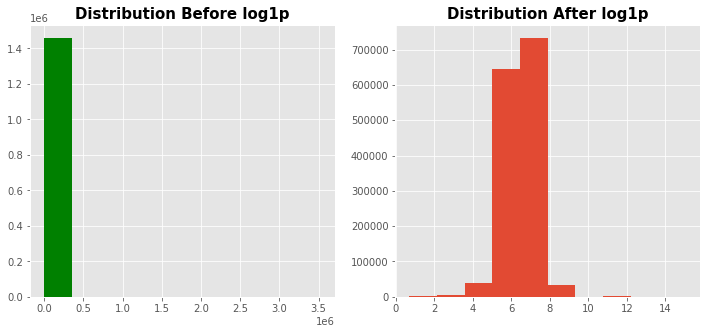

In [ ]:
# target변수에 log1p를 할 것.
fig, ax = plt.subplots(1,2, figsize=(12,5))
train['trip_duration'].hist(ax=ax[0], color='green')
ax[0].set_title('Distribution Before log1p', fontsize=15, fontweight='bold')
np.log1p(train['trip_duration']).hist(ax=ax[1])
ax[1].set_title('Distribution After log1p', fontsize=15, fontweight='bold')

In [129]:
# data split
x_train = train.drop(columns=['id', 'trip_duration', 'pickup_datetime', 'dropoff_datetime', 'speed', 'pickup_longitude_bin', 'pickup_latitude_bin', 'dropoff_longitude_bin', 'dropoff_latitude_bin'])
y_train = np.log1p(train['trip_duration'])  # 타겟에 log1p 
x_test = test.drop(columns=['id', 'pickup_datetime', 'pickup_longitude_bin', 'pickup_latitude_bin', 'dropoff_longitude_bin', 'dropoff_latitude_bin'])
x_train_columns, x_test_columns = x_train.columns, x_test.columns
x_train.shape, x_test.shape

((1458644, 24), (625134, 24))

In [130]:
# scaling
from sklearn.preprocessing import MinMaxScaler

for i in x_train.select_dtypes(exclude='object').columns:
  mm = MinMaxScaler().fit(x_train[[i]])
  x_train[i] = mm.transform(x_train[[i]])
  x_test[i] = mm.transform(x_test[[i]])

x_train = pd.DataFrame(x_train, columns=x_train_columns)
x_test = pd.DataFrame(x_test, columns=x_test_columns)

# Modeling (Catboost) - 라이브러리 설치 ↓↓↓↓↓↓↓

In [36]:
!pip install catboost
!pip install optuna

     |████████████████████████████████| 106 kB 4.2 MB/s 


# model selection은 KFold와 STratifiedKFold
 
 - train_test_split는 optuna의 model selection

---

# XGBoost Regressor model

In [63]:
import catboost
import optuna
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import mean_squared_log_error, mean_squared_error
import xgboost

In [131]:
kf = KFold(n_splits=7, shuffle=True, random_state=42)
sk = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
preds = np.zeros((x_test.shape[0],))
RMSLE = {}
params = {
    'booster':            'gbtree',
    'objective':          'reg:linear',
    'learning_rate':      0.1,
    'max_depth':          14,
    'subsample':          0.8,
    'colsample_bytree':   0.7,
    'colsample_bylevel':  0.7,
    'silent':             1,
    'tree_method' : 'gpu_hist'
}

for i, (train_index, val_index) in enumerate(kf.split(x_train, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[val_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[val_index]

  model_xgb = xgboost.XGBRegressor(n_estimators=5000, **params)
  model_xgb.fit(X_train, Y_train, eval_set=((X_train, Y_train), (X_valid, Y_valid)), verbose=100, early_stopping_rounds=70, eval_metric='rmse')

  preds += np.expm1(model_xgb.predict(x_test)) / kf.n_splits
  val_preds = model_xgb.predict(X_valid)
  RMSLE[i] = mean_squared_log_error(val_preds, Y_valid)
  print(f'{i+1}번째 RMSLE:{RMSLE[i]}\r')

[0]	validation_0-rmse:5.42158	validation_1-rmse:5.42221
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 70 rounds.
[100]	validation_0-rmse:0.261087	validation_1-rmse:0.384626
[200]	validation_0-rmse:0.207437	validation_1-rmse:0.38191
[300]	validation_0-rmse:0.170651	validation_1-rmse:0.381473
[400]	validation_0-rmse:0.14186	validation_1-rmse:0.381614
Stopping. Best iteration:
[334]	validation_0-rmse:0.159537	validation_1-rmse:0.381452

1번째 RMSLE:0.0031152915233507686
[0]	validation_0-rmse:5.42185	validation_1-rmse:5.42032
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 70 rounds.
[100]	validation_0-rmse:0.264731	validation_1-rmse:0.379579
[200]	validation_0-rmse:0.209633	validation_1-rmse:0.377443
[300]	validation_0-rmse:0.171688	validation_1-rmse:0.377155
Stopping. Best iteration:
[268]	v

Text(0.5, 0, 'RMSLE')

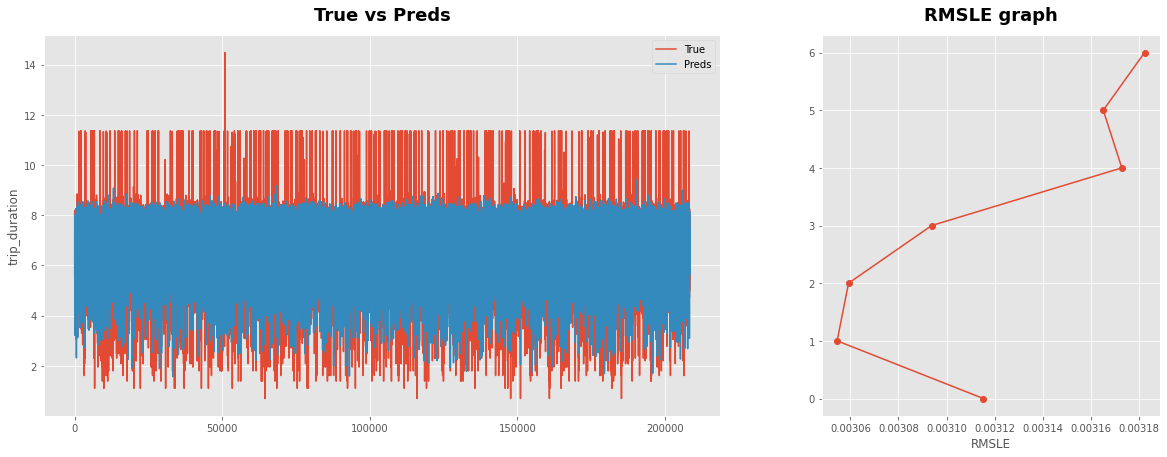

In [132]:
fig, ax = plt.subplots(1,2, figsize=(20,7), gridspec_kw={'width_ratios':[2, 1]})
sns.lineplot(x=Y_valid.reset_index(drop=True).index, y=Y_valid.reset_index(drop=True), label='True', ax=ax[0])
sns.lineplot(x=Y_valid.reset_index(drop=True).index, y=pd.Series(val_preds), label='Preds', ax=ax[0])
ax[0].set_title('True vs Preds', fontsize=18, fontweight='bold', pad=15)

plt.plot(pd.Series(RMSLE), pd.Series(RMSLE).index, marker='o')
plt.title('RMSLE graph', fontsize=18, fontweight='bold', pad=15)
plt.xlabel('RMSLE')

# Catboost Regressor

In [49]:
cat_features = list(x_train.select_dtypes('object').columns)
kf = KFold(n_splits=7, shuffle=True, random_state=42)
sk = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
preds = np.zeros((x_test.shape[0],))
RMSLE = {}

for i, (train_index, val_index) in enumerate(kf.split(x_train, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[val_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[val_index]

  model_cat = catboost.CatBoostRegressor(iterations=5000, learning_rate=0.02, loss_function='RMSE', eval_metric='RMSE', cat_features=cat_features, task_type='GPU')
  model_cat.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), verbose=100, early_stopping_rounds=70)

  preds += np.expm1(model_cat.predict(x_test)) / kf.n_splits
  val_preds = model_cat.predict(X_valid)
  RMSLE[i] = mean_squared_log_error(val_preds, Y_valid)
  print(f'{i+1}번째 RMSLE:{RMSLE[i]}\r')

0:	learn: 0.7860968	test: 0.7895481	best: 0.7895481 (0)	total: 10.7ms	remaining: 53.6s
100:	learn: 0.4752249	test: 0.4789122	best: 0.4789122 (100)	total: 902ms	remaining: 43.8s
200:	learn: 0.4425408	test: 0.4463798	best: 0.4463798 (200)	total: 1.79s	remaining: 42.9s
300:	learn: 0.4301821	test: 0.4341705	best: 0.4341705 (300)	total: 2.65s	remaining: 41.4s
400:	learn: 0.4230870	test: 0.4271865	best: 0.4271865 (400)	total: 3.53s	remaining: 40.5s
500:	learn: 0.4181230	test: 0.4223863	best: 0.4223863 (500)	total: 4.4s	remaining: 39.6s
600:	learn: 0.4146184	test: 0.4189921	best: 0.4189921 (600)	total: 5.28s	remaining: 38.7s
700:	learn: 0.4117338	test: 0.4161734	best: 0.4161734 (700)	total: 6.15s	remaining: 37.7s
800:	learn: 0.4094407	test: 0.4140119	best: 0.4140119 (800)	total: 7.03s	remaining: 36.8s
900:	learn: 0.4075077	test: 0.4121744	best: 0.4121744 (900)	total: 7.9s	remaining: 35.9s
1000:	learn: 0.4058751	test: 0.4106623	best: 0.4106623 (1000)	total: 8.78s	remaining: 35.1s
1100:	learn: 

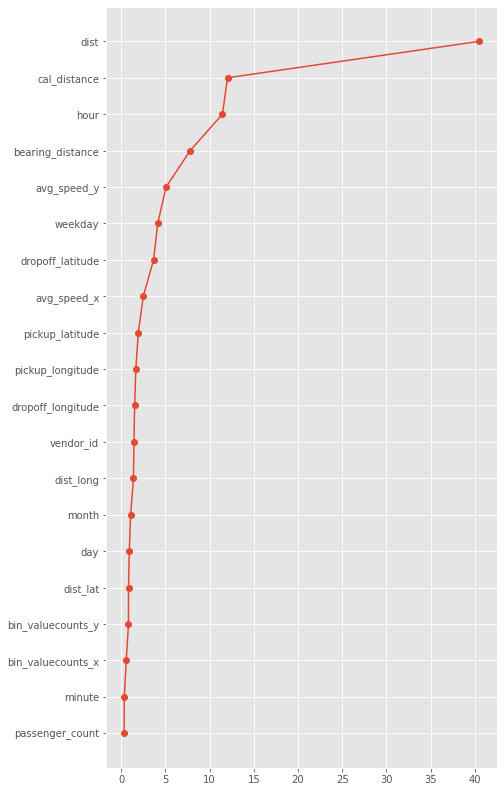

In [50]:
plt.figure(figsize=(7, 14))
plt.plot(pd.Series(model_cat.feature_importances_, index=x_train_columns).sort_values(ascending=True), pd.Series(model_cat.feature_importances_, index=x_train_columns).sort_values(ascending=True).index, marker='o')

Text(0.5, 0, 'RMSLE')

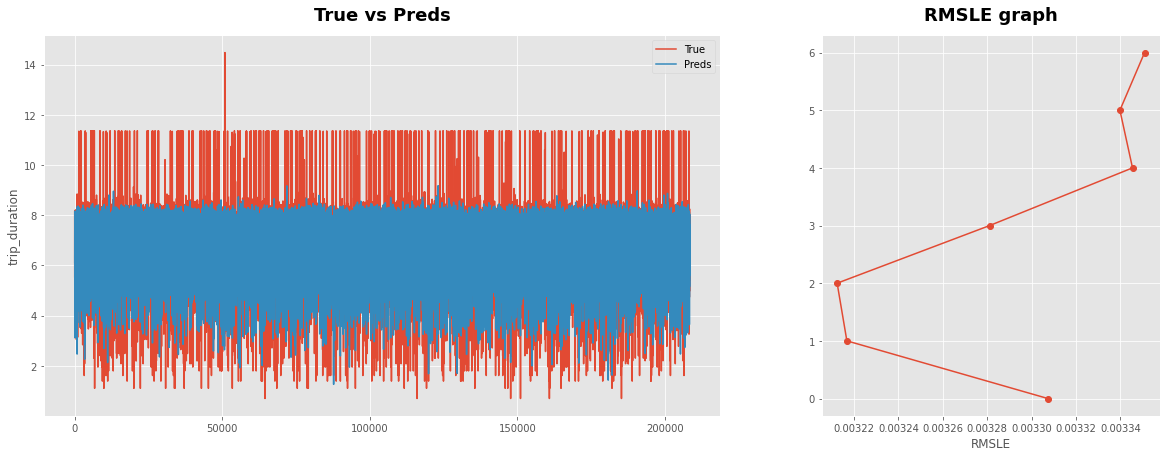

In [51]:
fig, ax = plt.subplots(1,2, figsize=(20,7), gridspec_kw={'width_ratios':[2, 1]})
sns.lineplot(x=Y_valid.reset_index(drop=True).index, y=Y_valid.reset_index(drop=True), label='True', ax=ax[0])
sns.lineplot(x=Y_valid.reset_index(drop=True).index, y=pd.Series(val_preds), label='Preds', ax=ax[0])
ax[0].set_title('True vs Preds', fontsize=18, fontweight='bold', pad=15)

plt.plot(pd.Series(RMSLE), pd.Series(RMSLE).index, marker='o')
plt.title('RMSLE graph', fontsize=18, fontweight='bold', pad=15)
plt.xlabel('RMSLE')

# 이상값은 표현을 잘 못했다. (모델 튜닝을 안했기 때문)


---
# After 하이퍼 파라미터 튜닝(Optuna) ver


In [52]:
cat_features = list(x_train.select_dtypes('object').columns)

def objective(trial,data=x_train,target=y_train):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2,random_state=42)
    params = {'iterations':trial.suggest_int("iterations", 2000, 25000),
             'loss_function':'RMSE',
              'task_type':"GPU",
              'eval_metric':'RMSE',
              'leaf_estimation_method':'Newton',
              'bootstrap_type': 'Bernoulli',
              'learning_rate' : trial.suggest_uniform('learning_rate',0.01,0.5),
              'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
              'subsample': trial.suggest_uniform('subsample',0,1),
              'random_strength': trial.suggest_uniform('random_strength',10,50),
              'depth': trial.suggest_int('depth',1,12),
              'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,50),
              'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
              'grow_policy' : 'Depthwise',
              'cat_features' : cat_features
               }
    model = catboost.CatBoostRegressor(**params)  
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)
        
    y_preds = model.predict(X_test)


    RMSE = np.sqrt(mean_squared_error(y_test, y_preds))
    
    return RMSE

In [53]:
OPTUNA_OPTIMIZATION = True

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)
print('Number of finished trials:', len(study.trials))
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

[I 2021-08-12 06:59:19,292] A new study created in memory with name: no-name-32d3e9dd-7405-4a10-897d-2f4f4e13aba4
[I 2021-08-12 06:59:42,507] Trial 0 finished with value: 0.39647399905568226 and parameters: {'iterations': 6107, 'learning_rate': 0.38834756119263125, 'reg_lambda': 84.62901893287228, 'subsample': 0.19002297037197746, 'random_strength': 40.48644823478277, 'depth': 5, 'min_data_in_leaf': 44, 'leaf_estimation_iterations': 5}. Best is trial 0 with value: 0.39647399905568226.
[I 2021-08-12 07:00:00,925] Trial 1 finished with value: 0.385448279379482 and parameters: {'iterations': 13511, 'learning_rate': 0.1859984060899892, 'reg_lambda': 32.602178870363964, 'subsample': 0.5202088002784351, 'random_strength': 18.360934034999513, 'depth': 10, 'min_data_in_leaf': 23, 'leaf_estimation_iterations': 2}. Best is trial 1 with value: 0.385448279379482.
[I 2021-08-12 07:00:49,079] Trial 2 finished with value: 0.39689794159593444 and parameters: {'iterations': 19707, 'learning_rate': 0.42

Number of finished trials: 10
Best trial: score 0.3819067840673012, params {'iterations': 18932, 'learning_rate': 0.06560839515914924, 'reg_lambda': 64.27255544901925, 'subsample': 0.5531155329573605, 'random_strength': 43.16777909718673, 'depth': 8, 'min_data_in_leaf': 30, 'leaf_estimation_iterations': 9}


In [54]:
cat_features = list(x_train.select_dtypes('object').columns)

kf = KFold(n_splits=7, shuffle=True, random_state=42)
sk = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
preds = np.zeros((x_test.shape[0],))
RMSLE = {}

params = {
    'iterations':study.best_params['iterations'],
    'loss_function':'RMSE',
    'task_type':"GPU",
    'eval_metric':'RMSE',
    'leaf_estimation_method':'Newton',
    'bootstrap_type': 'Bernoulli',
    'learning_rate' : study.best_params['learning_rate'],
    'reg_lambda': study.best_params['reg_lambda'],
    'subsample': study.best_params['subsample'],
    'random_strength': study.best_params['random_strength'],
    'depth': study.best_params['depth'],
    'min_data_in_leaf': study.best_params['min_data_in_leaf'],
    'leaf_estimation_iterations': study.best_params['leaf_estimation_iterations'],
    'grow_policy' : 'Depthwise',
    'cat_features' : cat_features
}

for i, (train_index, val_index) in enumerate(kf.split(x_train, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[val_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[val_index]

  model_cat = catboost.CatBoostRegressor(**params)
  model_cat.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), verbose=100, early_stopping_rounds=70)

  preds += np.expm1(model_cat.predict(x_test)) / kf.n_splits
  val_preds = model_cat.predict(X_valid)
  RMSLE[i] = mean_squared_log_error(val_preds, Y_valid)
  print(f'{i+1}번째 RMSLE:{RMSLE[i]}\r')

0:	learn: 0.7605004	test: 0.7640305	best: 0.7640305 (0)	total: 26.1ms	remaining: 8m 14s
100:	learn: 0.3938427	test: 0.4029213	best: 0.4029213 (100)	total: 2.46s	remaining: 7m 38s
200:	learn: 0.3805600	test: 0.3948246	best: 0.3948246 (200)	total: 4.56s	remaining: 7m 4s
300:	learn: 0.3721106	test: 0.3915196	best: 0.3915196 (300)	total: 6.57s	remaining: 6m 46s
400:	learn: 0.3656389	test: 0.3896526	best: 0.3896526 (400)	total: 8.55s	remaining: 6m 34s
500:	learn: 0.3602945	test: 0.3886056	best: 0.3886011 (499)	total: 10.5s	remaining: 6m 27s
600:	learn: 0.3555484	test: 0.3876360	best: 0.3876360 (600)	total: 12.6s	remaining: 6m 23s
700:	learn: 0.3513815	test: 0.3869918	best: 0.3869918 (700)	total: 14.6s	remaining: 6m 20s
800:	learn: 0.3476353	test: 0.3862776	best: 0.3862776 (800)	total: 16.8s	remaining: 6m 19s
900:	learn: 0.3445213	test: 0.3859039	best: 0.3859039 (900)	total: 18.9s	remaining: 6m 17s
1000:	learn: 0.3413213	test: 0.3855882	best: 0.3855771 (997)	total: 21s	remaining: 6m 15s
1100

Text(0, 0.5, 'KFold')

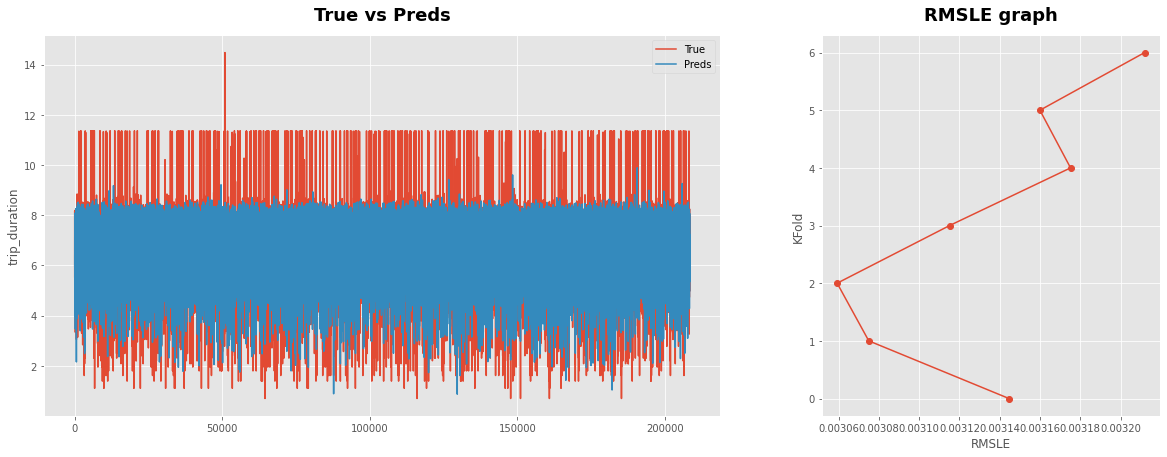

In [60]:
fig, ax = plt.subplots(1,2, figsize=(20,7), gridspec_kw={'width_ratios':[2, 1]})
sns.lineplot(x=Y_valid.reset_index(drop=True).index, y=Y_valid.reset_index(drop=True), label='True', ax=ax[0])
sns.lineplot(x=Y_valid.reset_index(drop=True).index, y=pd.Series(val_preds), label='Preds', ax=ax[0])
ax[0].set_title('True vs Preds', fontsize=18, fontweight='bold', pad=15)

plt.plot(pd.Series(RMSLE), pd.Series(RMSLE).index, marker='o')
plt.title('RMSLE graph', fontsize=18, fontweight='bold', pad=15)
plt.xlabel('RMSLE')
plt.ylabel('KFold')

In [133]:
submit = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/nyc-taxi-trip-durationsample_submission.csv')
submit['trip_duration'] = preds
submit

,id,trip_duration
0,id3004672,813.992821
1,id3505355,605.760376
2,id1217141,434.412155
3,id2150126,1016.862305
4,id1598245,379.236137
...,...,...
625129,id3008929,295.321226
625130,id3700764,1490.472046
625131,id2568735,1751.681412
625132,id1384355,6457.733459


In [134]:
submit.to_csv('/content/drive/MyDrive/dataset/kaggle/nyc_submit4.csv', index=False)

# To Do
- 역효과 나는 FE 제거하고 모델링
- 날씨 외부 데이터 사용하기

# 리더보드 동향
 1. FE, Catboostregressor, hyperparameter tuning(optuna) : LB 0.40878
 2. cluster(n_cluster=3, object화, bin컬럼 round=3), catboost : LB 0.43321 ==> 0.02443↑
 3. FE, catboost, hyperparameter tuning(optuna), without cluster, scailing : LB 0.40698 ==> 0.0018↓
 4. FE, xgboost, hyperparameter tuning(optuna), scailing, without cluster : LB 0.38902 ==> 0.01976↓
 5. FE, xgboost, hyperparameter tuning(optuna), scailing, cluster : LB 0.38807 ==> 0.02070↓



# 이 프로젝트를 하면서 느낀 점

- FE(Feature Engineering)는 아이디어 싸움이다!


- 모델링의 성능을 좌우하는 것은 다양한 모델 알고리즘(linear-regression, svm, xgb, catboost, lightbgm...)이 아니라 **세심한 Feature Engineering**이다.
  - 해당 프로젝트 뿐만 아니라 kaggle, dacon competition을 참여 하면서 느낀 점은 FE는 competition점수와 직결 되어있다.
  - 그러나 다양한 FE method들이 있지만 데이터마다 효과가 있는 FE 아이디어들이 있지만, 역효과가 나는 FE method들도 많다.
  - 데이터마다 효과적인 FE method를 찾아야한다.
  - 해당 데이터를 질 높은 데이터 셋으로 만들어야 한다. ==> 꼼꼼한 EDA는 필수!


> "AI를 요리에 비유하자면 data는 food에 해당한다. 품질 좋은 데이터를 사용 한다는 것은 품질 좋은 재료를 가지고 요리를 한다는 것(모델을 학습시킨다는 것)을 의미한다."

> "머신러닝 작업의 80%는 질 좋은 데이터를 구축하는 것이고 20%은 모델을 학습하는 것이다."

> Andrew Ng 교수님